In [13]:
import sys
sys.path.append("/home/ubuntu/fastai/")

In [55]:
import fastai
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
from glob import glob
import pandas as pd
import helper
from tqdm import tqdm
import hashlib
from urllib import request

In [22]:
!rm -rf data/tmp

In [15]:
%matplotlib inline
%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
?ImageClassifierData

In [17]:
ls data

leafsnap-dataset.tar  processed/  tmp/  train/  valid/


In [12]:
?ImageClassifierData.from_paths

In [18]:
def get_data(sz, bs):
    ### doing some transformations 
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on,
                           max_zoom=1.1)
    data = ImageClassifierData.from_paths(path='data'
            , num_workers=8
            , tfms=tfms, bs=bs)
    #return data.resize(sz, 'tmp')
    return data if sz>300 else data.resize(340, 'tmp')

In [19]:
sz = 224 # size of image
arch = resnet50 #model architecture.. model has 101 layers
bs=128 # batch size; number of images to process at one time

In [23]:
data = get_data(sz, bs)
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(lrs=1e-2, n_cycle=3)

                                                    
100%|██████████| 2/2 [00:02<00:00,  1.31s/it]


epoch      trn_loss   val_loss   accuracy                
    0      1.348356   0.814414   0.707819  
    1      0.833778   0.367185   0.851852                 
    2      0.617642   0.264132   0.855967                 



[array([0.26413]), 0.8559670887366244]

** Train with data augmentation **


In [25]:
learn.precompute = False
learn.fit(lrs=1e-2, n_cycle=5, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                  
    0      0.307917   0.241636   0.876543  
    1      0.310401   0.247199   0.872428                 
    2      0.301667   0.221062   0.884774                  
    3      0.291389   0.241686   0.872428                  
    4      0.284156   0.204627   0.897119                 



[array([0.20463]), 0.8971193418090726]

** Train more with layer unfreezing **


In [29]:
learn.unfreeze()

In [30]:
lr=1e-2
lr=np.array([lr/18,lr/6,lr/2])

In [31]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)


epoch      trn_loss   val_loss   accuracy                  
    0      0.5184     0.226679   0.855967  
    1      0.427658   0.264739   0.860082                  
    2      0.355143   0.209731   0.880658                  
    3      0.320402   0.21689    0.872428                 
    4      0.283279   0.199564   0.872428                  
    5      0.255386   0.189334   0.868313                  
    6      0.235175   0.188947   0.868313                 



[array([0.18895]), 0.868312753522347]

** calculate accuracy with test time augmentation **

In [32]:
log_preds,y = learn.TTA()
preds = np.mean(np.exp(log_preds),axis=0)
(metrics.log_loss(y,preds), accuracy_np(preds,y))

(0.18232223386613391, 0.8888888888888888)

In [33]:
predicted_class = np.argmax(preds, axis=1)
confidence = np.max(preds, axis=1)

In [34]:
predictions_df = pd.DataFrame ({'actual': y, 'pred': predicted_class,'image':learn.data.val_ds.fnames,'conf':confidence})

In [35]:
predictions_df['actual_class'] = predictions_df['actual'].apply(lambda x : data.classes[x])
predictions_df['pred_class'] = predictions_df['pred'].apply(lambda x : data.classes[x])

In [39]:
predictions_df.head(10)


,actual,pred,image,conf,actual_class,pred_class
0,0,0,valid/acer_palmatum/13001152966643.jpg,0.997140,acer_palmatum,acer_palmatum
1,0,0,valid/acer_palmatum/13001152962949.jpg,0.996189,acer_palmatum,acer_palmatum
2,0,0,valid/acer_palmatum/13001152960756.jpg,0.996231,acer_palmatum,acer_palmatum
3,0,0,valid/acer_palmatum/13001152963177.jpg,0.997035,acer_palmatum,acer_palmatum
4,0,0,valid/acer_palmatum/1249061360_0000.jpg,0.994954,acer_palmatum,acer_palmatum
5,0,0,valid/acer_palmatum/1259110850_0110.jpg,0.996616,acer_palmatum,acer_palmatum
6,0,0,valid/acer_palmatum/13001152963635.jpg,0.987023,acer_palmatum,acer_palmatum
7,0,0,valid/acer_palmatum/13001152966520.jpg,0.996898,acer_palmatum,acer_palmatum
8,0,0,valid/acer_palmatum/13001152968760.jpg,0.968169,acer_palmatum,acer_palmatum
9,0,0,valid/acer_palmatum/13001152961059.jpg,0.996839,acer_palmatum,acer_palmatum


In [52]:
def predict_class(image_path):
    trn_tfms, val_tfms = tfms_from_model(arch, sz)
    im = val_tfms(np.array(open_image(image_path)))

    preds = learn.predict_array(im[None])
    class_idx = np.argmax(preds)
    print(data.classes[class_idx],np.max(preds))
    
    img = PIL.Image.open(image_path);
    #return img
    
    return helper.get_top_n_predictions(np.exp(preds), data.classes)
    #return np.argmax(preds)

def predict_class_web(url,ext="jpg"):
    url_hash = hashlib.md5(url.encode('utf-8')).hexdigest()
    file_name = f'data/downloaded/{url_hash}.{ext}'
    f = open(file_name, 'wb')
    f.write(request.urlopen(url).read())
    f.close()
    
    return predict_class(file_name)

In [53]:
!mkdir -p data/downloaded

In [58]:
predict_class_web("http://dendroapp.frec.vt.edu/VT_Assets/Fact_Sheets/images/Juglans%20cinerea/leaf1.jpg")

fraxinus_nigra -0.30222416


[('fraxinus_nigra', 0.73917234),
 ('juglans_cinerea', 0.2173283),
 ('aesculus_pavi', 0.020245008),
 ('prunus_sargentii', 0.01457027),
 ('cryptomeria_japonica', 0.002758029)]

** Confusion Matrix**

In [40]:
labels = learn.data.classes
cm = confusion_matrix(predictions_df['actual'], predictions_df['pred'])

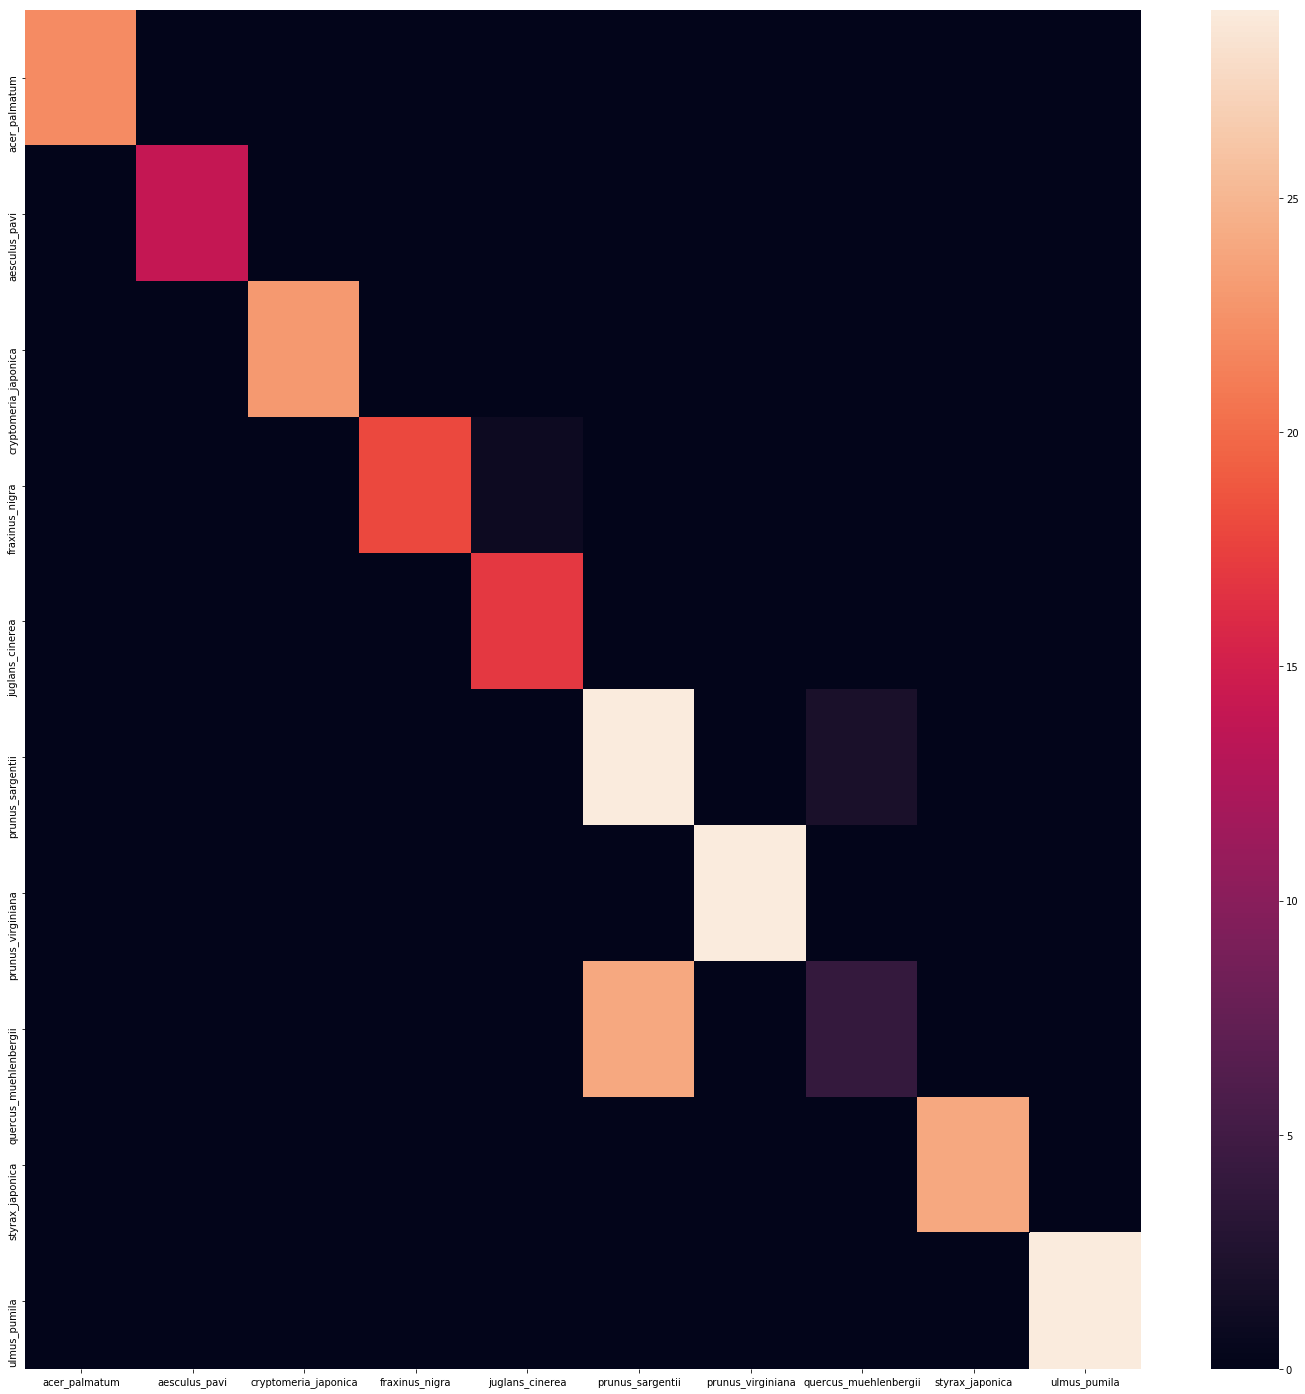

In [59]:
fig, ax = plt.subplots(figsize=(25, 25))
_ = sns.heatmap(cm, ax=ax, yticklabels=labels, xticklabels=labels, robust=True)